In [2]:
%matplotlib inline 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models
import torchvision.transforms as transforms
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
vgg = list(torchvision.models.vgg19_bn(pretrained=True).features[:-1].children())
vgg = nn.Sequential(*[nn.AvgPool2d(2) if isinstance(n, nn.MaxPool2d) else n for n in vgg]).to(dev)
for param in vgg.parameters():
    param.requires_grad = False

In [5]:
# All conv layers. Replace maxpool with average as proposed in paper?
conv_ids = [int(idx) for idx, m in vgg.named_children() if isinstance(m, nn.Conv2d)]
len(conv_ids)

16

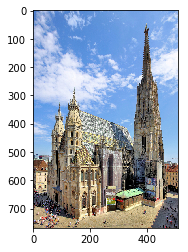

In [14]:
p = np.array(Image.open('stephansdom_small.png'))
plt.imshow(p)
plt.show()

In [59]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

tnorm = transforms.Compose([
    transforms.ToTensor(), # 0..1
    transforms.Normalize(mean=mean, std=std)    
])

class Denormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
    
class Clip:
    def __call__(self, tensor):
        return torch.clamp(tensor, min=0., max=1.)
    
class ToNumpy():
    def __call__(self, tensor):
        t = np.transpose(tensor.detach().numpy(), (1, 2, 0))
        t *= 255.
        return t.astype(np.uint8)
        
tdenorm = transforms.Compose([
    Denormalize(mean=mean, std=std),
    Clip(),
    ToNumpy()    
])

In [60]:
def content_loss(a, b):
    return F.mse_loss(a, b, size_average=True)

In [61]:
from tqdm import tqdm

class GrabActivations:    
    def __call__(self, module, inputs, outputs):
        self.activations = outputs

def reconstruct(net, dev, layer_id, crit, image, niter=100):
    
    grab = GrabActivations()    
    
    image = image.to(dev).unsqueeze(0)   

    with net[layer_id].register_forward_hook(grab):
        net(image)
        act_ref = grab.activations.clone()   
        
    x = torch.tensor(torch.randn_like(image) * 1e-1, requires_grad=True)
    
    opt = optim.SGD([x], lr=1e-1, momentum=False)
    
    with net[layer_id].register_forward_hook(grab), tqdm(total=niter) as t:
        
        for idx in range(niter):
            
            #opt.zero_grad()
    
            if x.grad is not None:
                x.grad.zero_()

            net(x)
            act_x = grab.activations

            loss = crit(act_ref, act_x)
            loss.backward()    
            
            lr = 1e-2 / torch.sqrt((x.grad**2).mean()).item()      
            for param_group in opt.param_groups:
                param_group['lr'] = lr                
            
            #x.data.sub_(x.grad * lr)
            opt.step()
            
            t.set_postfix(loss=loss.item(), grad=torch.norm(x.grad).item(), lr=lr)
            t.update()
            
        return x        

In [65]:
layer_id = conv_ids[1]
x = reconstruct(vgg, dev, layer_id, content_loss, tnorm(p), niter=200)
xx = tdenorm(x.squeeze().cpu())

100%|███████████████████████████████████████| 200/200 [00:20<00:00,  9.83it/s, grad=0.00062, loss=0.00249, lr=1.75e+04]


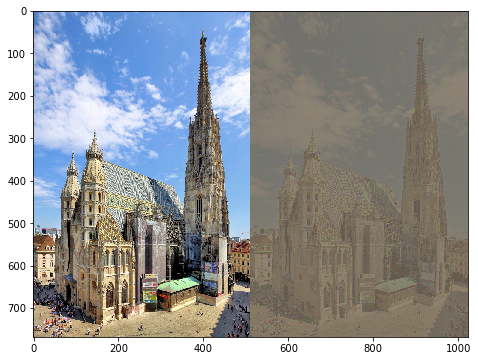

In [66]:
plt.figure(figsize=(12,6))
plt.imshow(np.hstack((p, xx)))
plt.show()